# Machine Learning Toolkit (Binary Classification)
## This program provides a tool used to do create a machine learning model on a given dataset.

## Currently works with binary classifcation, single label problems. Will update to do regression and multi-label problems.

Must type in the filename, input/output/numeric/categorical column names.

Take a dataset from Kaggle or from your own and upload it to this program: https://www.kaggle.com/datasets

In [1]:
import pandas as pd
import numpy as np
import sklearn as scikit_learn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import mrmr
from mrmr import mrmr_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
import xgboost
import catboost
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import joblib as joblib
from joblib import dump, load
import shap
np.random.seed(1000)
rstate = 12

In [2]:
pip install mrmr_selection

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [6]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
# filename = #--->  Insert file name here  <----#

filename = "weatherAUS.csv"

raw_df = pd.read_csv(filename)
#raw_df = pd.read_excel(filename)

In [8]:
df = raw_df.copy()

In [9]:
df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


In [10]:
# By default, we should cut rows that have missing series of values (cutMissing), impute the data (Impute), and remove very large data values (removeBig)
def preprocess(df, input_cols, label_cols, numeric_cols, categorical_cols, Impute=True, cutMissingRows=True, oneHotEncode=True, removeBig=False, N=20000, Scaling=False, scalingMethod='MinMaxScaler', QuantileTransformer=False, Normalize=False):
    if oneHotEncode == True:
        print("oneHotEncode")
        # One Hot Encode catagorical variables
        from sklearn.preprocessing import OneHotEncoder
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoder.fit(raw_df[categorical_cols])
        encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
        df[encoded_cols] = encoder.transform(df[categorical_cols])
        input_cols = numeric_cols + encoded_cols
    
    if Impute == True:
        print("Impute")
        # Impute the remaining missing numeric data
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy = 'mean')
        imputer.fit(df[numeric_cols])
        df[numeric_cols] = imputer.transform(df[numeric_cols])
        
    if cutMissingRows == True:
        print("cutMissingRows")
        # Drop rows with missing values
        df = df.dropna()
    
    if removeBig == True:
        print("removeBig")
        # Remove rows that have a value greater than N for any column. Default N is 20000
        for column  in df[numeric_cols]:
            df = df.drop(df.index[df[column] > N])
    
    if Scaling == True:
        print("Scaling")
        # Scaling the input features for a chosen method. Default is MinMaxScaler.
        if scalingMethod == 'MinMaxScaler': 
            print("MinMaxScaler")
            # This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
        elif scalingMethod == 'RobustScaler':
            print("RobustScaler")
            # This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
            from sklearn.preprocessing import RobustScaler
            scaler = RobustScaler()
        elif scalingMethod == 'MaxAbsScaler':
            print("MaxAbsScaler")
            # Scale each feature by its maximum absolute value.
            from sklearn.preprocessing import MaxAbsScaler
            scaler = MaxAbsScaler()
        elif scalingMethod == 'StandardScaler':
            print("StandardScaler")
            # Standardize features by removing the mean and scaling to unit variance.
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
        scaler.fit(df[numeric_cols])
        df[numeric_cols] = scaler.transform(df[numeric_cols])
        
    if QuantileTransformer == True:  
        print("QuantileTransformer")
        # transforms the features to follow a uniform or a normal distribution.
        from sklearn.preprocessing import QuantileTransformer
        qt = QuantileTransformer(output_distribution='normal').fit(df[numeric_cols])
        df[numeric_cols] = qt.transform(df[numeric_cols])
        
    if Normalize == True:  
        print("Normalize")
        # Normalize the data
        from sklearn.preprocessing import Normalizer
        normalizer = Normalizer().fit(df[numeric_cols])
        df[numeric_cols] = normalizer.transform(df[numeric_cols])
        
    
    return df, input_cols

In [11]:
# Split data into input and output sets
def split(df, input_cols, label_cols):
    input_df = df[input_cols].copy()
    output_df = df[label_cols].copy()
    
    return input_df, output_df

In [12]:
#rebalance the imbalanced data with a chosen label
def rebalance(input_df, label_df, type='RandomUnderSampler'):
    if type == 'RandomUnderSampler':
        # random undersampling reduces the number of majority class randomly down to the desired ratio against the minority class.
        from imblearn.under_sampling import RandomUnderSampler
        rebalance = RandomUnderSampler()
        input_df2, label_df2 = rebalance.fit_resample(input_df, label_df)
    elif type == 'RandomOverSampler':
        # Naive random over-sampling.
        from imblearn.over_sampling import RandomOverSampler
        rebalance = RandomOverSampler()
        input_df2, label_df2 = rebalance.fit_resample(input_df, label_df)
    elif type == 'SMOTE':
        # SMOTE is a technique to up-sample the minority classes while avoiding overfitting.
        from imblearn.over_sampling import SMOTE
        rebalance = SMOTE()
        input_df2, label_df2 = rebalance.fit_resample(input_df, label_df)    
    elif type == 'ADASYN':
        # Adaptive Synthetic (ADASYN) algorithm. This method is similar to SMOTE but it generates different number of samples depending on an estimate of the local distribution of the class to be oversampled.
        from imblearn.over_sampling import ADASYN
        rebalance = ADASYN()
        input_df2, label_df2 = rebalance.fit_resample(input_df, label_df)                   
    else:
        print("Cannot do")
        input_df2, label_df2 = input_df, label_df
        
    return input_df2, label_df2  

In [13]:
def feature_selection(input_df, output_df, method="MRMR", type='f_classif', N=20, per=10):
    if method=="MRMR":
        selected_features = mrmr_classif(X=input_df, y=output_df, K=N)
        input_df_new = input_df[selected_features]
    elif method=="SelectKBest":
        if type=='f_classif':
            best_features =  SelectKBest(f_classif, k=N)
            best_features.fit(input_df, output_df)
        elif type=='chi2':
            best_features =  SelectKBest(chi2, k=N)
            best_features.fit(input_df, output_df)
        # Get columns to keep and create new dataframe with those only
        cols_idxs = best_features.get_support(indices=True)
        input_df_new = input_df.iloc[:,cols_idxs]
    elif method=="SelectPercentile": # Select features according to a percentile of the highest scores.
        if type=='f_classif':
            best_features =  SelectPercentile(f_classif, percentile=per)
            best_features.fit(input_df, output_df)
        elif type=='chi2':
            best_features =  SelectPercentile(chi2, percentile=per)
            best_features.fit(input_df, output_df)
        # Get columns to keep and create new dataframe with those only
        cols_idxs = best_features.get_support(indices=True)
        input_df_new = input_df.iloc[:,cols_idxs]
    elif method=="VarianceThreshold": # Feature selector that removes all low-variance features.
        best_features = VarianceThreshold()
        best_features.fit(input_df)
        cols_idxs = best_features.get_support(indices=True)
        input_df_new = input_df.iloc[:,cols_idxs]
    
    return input_df_new, list(input_df_new.columns)

In [14]:
# define a model to use and its set of parameters
def get_classifier(alg):
    est_rs = 1000
    if alg == 'rf':
        from sklearn.ensemble import RandomForestClassifier
        estimator = RandomForestClassifier(random_state=est_rs)
        param_vals = {'max_depth': [10, 20, 30, 50, 100, 150, 200], 'n_estimators': [20, 30, 50, 70, 100, 120],
                      'max_samples': [0.75, 0.80, 0.85, 0.90, 0.95]}
    elif alg == 'dt':
        from xgboost import DecisionTreeClassifier
        estimator = DecisionTreeClassifier()
        param_vals = {'max_depth': [2, 3, 4, 5, 8], 'min_samples_split': [2, 3, 4, 5, 7, 10], 
                      'random_state': [0, 1, 5, 10,50,100]}
    elif alg == 'xgb':
        from xgboost import XGBClassifier
        estimator = XGBClassifier(objective='binary:logistic', booster='gbtree', nthread=4, eval_metric='auc',
                                  use_label_encoder=False, random_state=est_rs)
        param_vals = {'max_depth': [2, 3, 4, 6, 8], 'n_estimators': [80, 90, 100, 110, 120, 200], 
                      'learning_rate': [0.00001, 0.0001, 0.001, 0.01], 'colsample_bytree': [0.85, 0.90, 0.95, 1.0]}
    elif alg == 'cat':
        from catboost import CatBoostClassifier
        cat_features = []
        estimator = CatBoostClassifier(loss_function='Logloss', nan_mode='Min', cat_features=cat_features,
                                       one_hot_max_size=31, random_state=est_rs)
        param_vals = {'max_depth': [4, 8, 12, 16, 20], 'n_estimators': [20, 30, 50, 70, 100, 120], 
                      'learning_rate': [0.0001, 0.001, 0.01, 0.1]}
    elif alg == 'sgd_elastic':
        from sklearn.linear_model import SGDClassifier # stochastic gradient descent (SGD)
        estimator = SGDClassifier(loss='log', penalty='elasticnet')
        param_vals = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1], 'l1_ratio': [0, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, .75, 0.9, 1]}
    elif alg == 'sgd_l2':
        from sklearn.linear_model import SGDClassifier
        estimator = SGDClassifier(loss='log', penalty='l2')
        param_vals = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1], 'l1_ratio': [0, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, .75, 0.9, 1]}
    elif alg == 'lr_l2': # Logistic Regression
        from sklearn.linear_model import LogisticRegression
        estimator = LogisticRegression(penalty='l2')
        param_vals = {'random_state': [0, 1, 5, 10,50,100], 'l1_ratio': [0, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, .75, 0.9, 1]}
    elif alg == 'lr':
        from sklearn.linear_model import LogisticRegression
        estimator = LogisticRegression()
        param_vals = {'random_state': [0, 1, 5, 10,50,100], 'l1_ratio': [0, 0.1, 0.15, 0.25, 0.4, 0.5, 0.6, .75, 0.9, 1]}
    elif alg == 'lasso':
        from sklearn import linear_model
        estimator = linear_model.Lasso()
        param_vals = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1], 'tol': [0.00001, 0.0001, 0.001, 0.01, 0.1], 'max_iter': [1000, 1500, 2000, 2500]}
    elif alg == 'ridge':
        from sklearn.linear_model import Ridge
        estimator = Ridge()
        param_vals = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1], 'tol': [0.00001, 0.0001, 0.001, 0.01, 0.1], 'max_iter': [1000, 1500, 2000, 2500]}        
    elif alg == 'svm':
        from sklearn import svm
        estimator = svm.SVC(probability=True)
        param_vals = {'C': [0.5, 1, 1.5, 2, 2.5, 3], 'degree': [2, 3, 4, 5]}            
    elif alg == 'knn': # k-nearest neighbors
        from sklearn.neighbors import KNeighborsClassifier
        estimator = KNeighborsClassifier()
        param_vals = {'n_neighbors': [5, 10, 15, 20, 25, 30], 'leaf_size': [20, 30, 40, 50]}  
        
    return estimator, param_vals

In [15]:
def train_tune(estimator, param_vals, X_train, y_train, strategy='random', itr=20):
    if strategy == 'random':
        random_df = RandomizedSearchCV(estimator, param_distributions=param_vals,
                              n_iter=itr, random_state=256, n_jobs=-1)
        random_df.fit(X_train, y_train)
        best_model = random_df.best_estimator_

    elif strategy == 'bayesian':
        bayes_df = BayesSearchCV(estimator, param_vals,
                              n_iter=itr, random_state=256, n_jobs=-1)
        bayes_df.fit(X_train, y_train)
        best_model = bayes_df.best_estimator_
    elif strategy == 'grid':
        grid_df = GridSearchCV(estimator, param_vals, n_jobs=-1, return_train_score=True)
        grid_df.fit(X_train, y_train)
        best_model = grid_df.best_estimator_   
        
    return best_model

In [16]:
def train_tune(estimator, param_vals, X_train, y_train, strategy='random', itr=20):
    if strategy == 'random':
        random_df = RandomizedSearchCV(estimator, param_distributions=param_vals,
                              n_iter=itr, random_state=256, n_jobs=-1)
        random_df.fit(X_train, y_train)
        best_model = random_df.best_estimator_

    elif strategy == 'bayesian':
        bayes_df = BayesSearchCV(estimator, param_vals,
                              n_iter=itr, random_state=256, n_jobs=-1)
        bayes_df.fit(X_train, y_train)
        best_model = bayes_df.best_estimator_
    elif strategy == 'grid':
        grid_df = GridSearchCV(estimator, param_vals, n_jobs=-1, return_train_score=True)
        grid_df.fit(X_train, y_train)
        best_model = grid_df.best_estimator_   
        
    return best_model

In [17]:
_scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

def perf_measure(y_real, y_pred):
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # true positive rate
    tnr = TN/(TN + FP) # true negative rate

    return "TP:" + str(TP) + " FP:" + str(FP) + " TN:" + str(TN) + " FN:" + str(FN), "TP Rate:" + str(tpr) + " TN Rate:" + str(tnr)

In [18]:
def plot_sklearn_roc_curve(test_real, test_pred, train_real, train_pred, algo, label):  
    plt.figure(0).clf()

    fpr, tpr, _ = roc_curve(train_real, train_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr,label="Training Set, auc="+str(roc_auc))

    fpr, tpr, _ = roc_curve(test_real, test_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr,label="Test Set, auc="+str(roc_auc))
    plt.plot([0, 1], [0, 1], color = 'g')
    plt.legend(loc=0)
    plt.xlabel("False Postive Rate")
    plt.ylabel("True Postive Rate")
    
    filename = algo + '_' + label + ".png"
    plt.savefig(filename)
    plt.show()

In [19]:
# Get the feature variables and labels
#input_cols = df.loc[:, "---> INPUT COLUMNS NAMES or RANGE <----"].columns.tolist()
#label_cols = df.loc[:, "---> LABEL COLUMNS NAME or RANGE <----"].columns.tolist()

input_cols = df.loc[:, 'MinTemp':'RainToday'].columns.tolist()
label_cols = 'RainTomorrow'


input_df = df.loc[:, input_cols]

numeric_cols = input_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = input_df.select_dtypes('object').columns.tolist()

In [20]:
input_df.head(10)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No
5,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No
6,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No
7,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No
8,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No
9,13.1,30.1,1.4,NaN,NaN,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes


In [21]:
numeric_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [22]:
categorical_cols

['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [23]:
algorithms = ['rf','xgb','sgd_elastic']

options = {
    'oneHotEncode' : True, 
    'Impute': True, 
    'cutMissingRows' : True,
    'removeBig': False, 
    'removeBig_N': 40000, 
    'Scaling': False, 
    'scalingMethod': "MinMaxScaler", 
    'QuantileTransformer':False, 
    'Normalize':False,
    'rebalance' : False,
    'rebalance_type':'SMOTE',
    'FeatureSelection': True,
    'method':"MRMR", 
    "type":'SelectKBest', 
    'N_features':12, 
    'per':10,
    'strategy':'bayesian', 
    'itr':20,
    'CV':5,
    'SHAP': False
}

with open("parameter_setup.txt", 'w') as f: 
    for key, value in options.items(): 
        f.write('%s:%s\n' % (key, value))
f.close()
        
def data_prep(df, input_cols, label_cols, numeric_cols, categorical_cols, options):
    #Preprocess data
    df_new, input_cols = preprocess(df, input_cols, label_cols, numeric_cols, categorical_cols, oneHotEncode=options['oneHotEncode'], 
                    Impute=options['Impute'], cutMissingRows=options['cutMissingRows'],
                    removeBig=options['removeBig'], N=options['removeBig_N'],
                   Scaling=options['Scaling'], scalingMethod=options['scalingMethod'], 
                        QuantileTransformer=options['QuantileTransformer'],
                        Normalize=options['Normalize'])

    #Split data into train/val/test sets
    train_val_df, test_df = train_test_split(df_new, test_size=0.2, random_state=42)
    
    #Seperate the inputs and outputs for training data
    input_df_train, output_df_train = split(train_val_df, input_cols, label_cols)
    
    #Seperate the inputs and outputs for test data
    input_df_test, output_df_test = split(test_df, input_cols, label_cols)
    
    return input_df_train, output_df_train, input_df_test, output_df_test
    #return train_val_df, test_df
    
input_df_train, output_df_train, input_df_test, output_df_test  = data_prep(df, input_cols, label_cols, numeric_cols, categorical_cols, options)  
#train_val_df, test_df = data_prep(df, input_cols, label_cols, numeric_cols, categorical_cols, options) 

oneHotEncode
Impute
cutMissingRows


In [24]:
input_df_train.head(10)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes,RainToday_nan
74320,0.7,15.0,0.2,5.468232,7.611178,20.0,7.0,6.0,100.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
35329,18.8,28.6,0.0,4.000000,7.900000,48.0,11.0,33.0,65.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
28773,8.8,19.0,0.0,2.200000,7.611178,57.0,22.0,30.0,44.0,42.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
61768,1.1,10.5,0.0,1.600000,0.200000,26.0,6.0,13.0,92.0,96.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
52229,-1.7,10.7,0.0,5.468232,7.611178,48.0,28.0,19.0,36.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101880,4.2,14.0,0.4,1.400000,9.100000,35.0,7.0,24.0,97.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
108334,10.6,22.6,0.0,8.400000,7.611178,43.0,24.0,22.0,51.0,23.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
96266,19.0,29.0,0.0,5.600000,7.611178,35.0,11.0,28.0,69.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
52780,4.4,13.1,0.0,5.468232,7.611178,37.0,7.0,13.0,99.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27302,13.3,21.8,0.0,5.468232,7.611178,70.0,33.0,24.0,50.0,44.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
output_df_train.head(10)

74320      No
35329      No
28773      No
61768     Yes
52229      No
101880     No
108334     No
96266      No
52780      No
27302      No
Name: RainTomorrow, dtype: object

In [26]:
if "Yes" in output_df_train.tolist() and "No" in output_df_train.tolist():
    output_df_train = output_df_train.map({'Yes': 1, 'No': 0})
output_df_train.head(10)

74320     0
35329     0
28773     0
61768     1
52229     0
101880    0
108334    0
96266     0
52780     0
27302     0
Name: RainTomorrow, dtype: int64

In [27]:
output_df_test.head(10)

23962      No
48619      No
38622     Yes
31532      No
8054       No
21123      No
101232     No
22417      No
97144      No
96203      No
Name: RainTomorrow, dtype: object

In [28]:
if "Yes" in output_df_test.tolist() and "No" in output_df_test.tolist():
    output_df_test = output_df_test.map({'Yes': 1, 'No': 0})
output_df_test.head(10)

23962     0
48619     0
38622     1
31532     0
8054      0
21123     0
101232    0
22417     0
97144     0
96203     0
Name: RainTomorrow, dtype: int64

In [29]:
def cross_validation(input_df_train, output_df_train, input_df_test, output_df_test, options, algorithms, _scoring):
    for algorithm in algorithms:
        filename = algorithm + ".txt"
        f = open(filename, "w")
        print("_____________________________________________________________________________________________________")
        print("Algorithm:", algorithm)
        print("Label:", output_df_train.name)
        f.write("_____________________________________________________________________________________________________")
        f.write("\nAlgorithm: %s"% algorithm)
        f.write("\nLabel: %s"% output_df_train.name)
        if options['rebalance'] == True:
            input_df_train_reb, output_df_train_reb = rebalance(input_df_train, output_df_train, options['rebalance_type'])
        else:
            input_df_train_reb = input_df_train.copy()
            output_df_train_reb = output_df_train.copy()
        if options['FeatureSelection'] == True:
            input_df_train_fs, selected_features = feature_selection(input_df_train_reb, output_df_train_reb, method=options['method'], type=options['type'], N=options['N_features'], per=options['per'])
        else:
            input_df_train_fs = input_df_train_reb.copy()
            selected_features = list(input_df_train_reb.columns)
        estimator, param_vals = get_classifier(algorithm)
        #if algorithm in ['rf', 'xgb', 'cat']:
            #estimator = CalibratedClassifierCV(estimator, method='sigmoid', cv=5)
        best_model = train_tune(estimator, param_vals, input_df_train_fs, output_df_train_reb, options['strategy'], itr=options['itr'])
        params = best_model.get_params()
        f.write("\nParameters: %s"%params)
        results = cross_validate(estimator=best_model,
                                   X=input_df_train_fs,
                                   y=output_df_train_reb,
                                   cv=options['CV'],
                                   scoring=_scoring,
                                   return_train_score=True, return_estimator=True)
        model_fit = results['estimator'][0]
        print(model_fit)
        #f.write("Training Accuracy scores %s"% results['train_accuracy'])
        f.write("\nMean Training Accuracy %s"% (results['train_accuracy'].mean()*100))
        #f.write("\nTraining Precision scores %s"% results['train_precision'])
        f.write("\nMean Training Precision %s"% results['train_precision'].mean())
        #f.write("\nTraining Recall scores %s"% results['train_recall'])
        f.write("\nMean Training Recall %s"% results['train_recall'].mean())
        #f.write("\nTraining F1 scores %s"% results['train_f1'])
        f.write("\nMean Training F1 Score %s"% results['train_f1'].mean())
        #f.write("\nTraining AUC scores %s"% results['train_roc_auc'])
        f.write("\nMean Training AUC Score %s"% results['train_roc_auc'].mean())
        #f.write("\nValidation Accuracy scores %s"% results['test_accuracy'])
        f.write("\nMean Validation Accuracy %s"% (results['test_accuracy'].mean()*100))
        #f.write("\nValidation Precision scores %s"% results['test_precision'])
        f.write("\nMean Validation Precision %s"% results['test_precision'].mean())
        #f.write("\nValidation Recall scores %s"% results['test_recall'])
        f.write("\nMean Validation Recall %s"% results['test_recall'].mean())
        #f.write("\nValidation F1 scores %s"% results['test_f1'])
        f.write("\nMean Validation F1 Score %s"% results['test_f1'].mean())
        #f.write("\nValidation AUC scores %s"% results['test_roc_auc'])
        f.write("\nMean Validation AUC Score %s"% results['test_roc_auc'].mean())
        probas_train = model_fit.predict_proba(input_df_train[selected_features])
        predictions_test = model_fit.predict(input_df_test[selected_features])
        probas_test = model_fit.predict_proba(input_df_test[selected_features])
        print(probas_test)
        acc_score = accuracy_score(output_df_test, predictions_test)
        f.write("\n Test Acuracy Score: %s"%acc_score)
        filename_prob = algorithm + "_" + output_df_test.name + "_prob.joblib"
        filename_pred = algorithm + "_" + output_df_test.name + "_pred.joblib"
        joblib.dump(probas_test, filename_prob)
        joblib.dump(predictions_test, filename_pred)
        modelname = algorithm + "_" + output_df_test.name + "_model.joblib"
        joblib.dump(model_fit, modelname)
        #"""
        if options['SHAP'] == True:
            explainer = shap.Explainer(model_fit.predict, input_df_train_fs[selected_features])
            shap_value = explainer(input_df_train_fs[selected_features])
            #shap.plots.beeswarm(shap_value, show=True)
            shap.summary_plot(shap_value, input_df_train_fs[selected_features], max_display=10, show=False)
            filename_shap = algorithm + "_" + output_df_train.name + "_shap.png"
            plt.savefig(filename_shap,dpi=700)
        #"""
        f.write('\n')
        # Plots the ROC curve using the sklearn methods
        plot_sklearn_roc_curve(output_df_test, probas_test[:, 1], output_df_train, probas_train[:, 1], algorithm, output_df_test.name)
    f.close()

_____________________________________________________________________________________________________
Algorithm: rf
Label: RainTomorrow


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.46it/s]


RandomForestClassifier(max_depth=20, max_samples=0.85, n_estimators=120,
                       random_state=1000)
[[0.62446271 0.37553729]
 [0.86965534 0.13034466]
 [0.54462023 0.45537977]
 ...
 [0.99045199 0.00954801]
 [0.96200058 0.03799942]
 [0.9446775  0.0553225 ]]


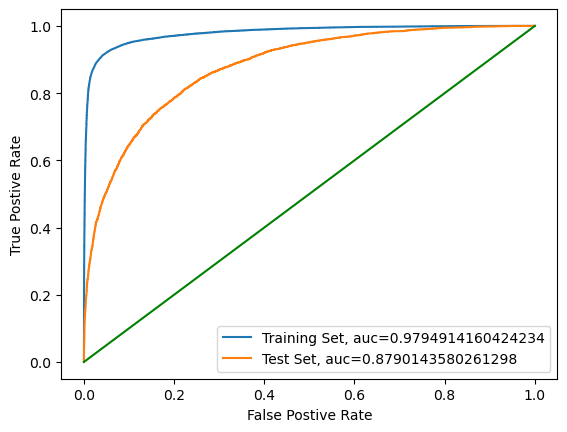

_____________________________________________________________________________________________________
Algorithm: xgb
Label: RainTomorrow


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.69it/s]


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.95, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=120, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)
[[0.5815789  0.4184211 ]
 [0.77529633 0.22470365]
 [0.6380903  0.3619097 ]
 ...
 [0.81774974 0.18225028]
 [0.82892674 0.17107327]
 [0.7959875  0.20401251]]


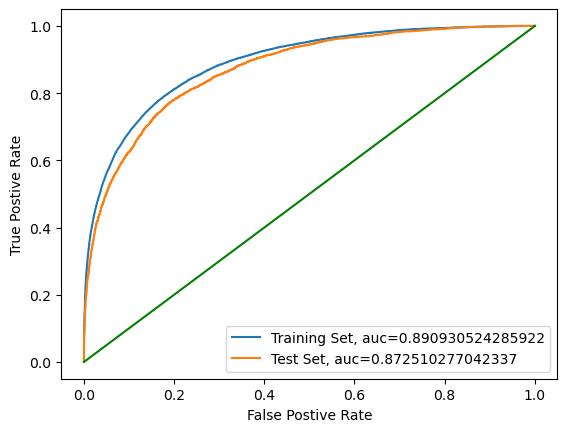

_____________________________________________________________________________________________________
Algorithm: sgd_elastic
Label: RainTomorrow


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.45it/s]


SGDClassifier(alpha=0.5, l1_ratio=0.25, loss='log', penalty='elasticnet')
[[0.61718555 0.38281445]
 [0.88920498 0.11079502]
 [0.85674386 0.14325614]
 ...
 [0.93498305 0.06501695]
 [0.91995386 0.08004614]
 [0.94607961 0.05392039]]


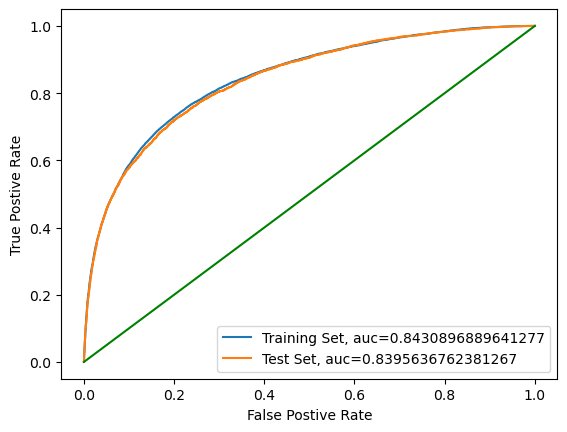

In [30]:
cross_validation(input_df_train, output_df_train, input_df_test, output_df_test, options, algorithms, _scoring)